In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chinnu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chinnu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chinnu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Define dataset files
files = [
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2013dev-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2013test-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2013train-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2014sarcasm-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2014test-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2015test-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2015train-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2016devtest-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt",
    "/Users/chinnu/Desktop/project/Gopi/2017_English_final/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt",
]

# Load data into Pandas DataFrame
data = []
for file in files:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 3:  # Ensure correct format
                tweet_id, sentiment, tweet = parts
                data.append([tweet, sentiment])

df = pd.DataFrame(data, columns=["tweet", "sentiment"])

# Encode sentiment labels
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["sentiment"] = df["sentiment"].map(label_mapping)

# Display dataset shape
print("Dataset Size:", df.shape)
df.head()


Dataset Size: (50324, 2)


,tweet,sentiment
0,Won the match #getin . Plus\u002c tomorrow is ...,2
1,Some areas of New England could see the first ...,2
2,@francesco_con40 2nd worst QB. DEFINITELY Tony...,0
3,#Thailand Washington - US President Barack Oba...,2
4,Did y\u2019all hear what Tony Romo dressed up ...,2


In [5]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load NLTK stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def regex_tokenizer(text):
    """Alternative tokenizer that extracts words without needing NLTK punkt"""
    return re.findall(r'\b\w+\b', text.lower())  # Extracts words using regex

def preprocess_text(text):
    """Function to clean and preprocess tweets without using nltk.word_tokenize()"""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+|\#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers

    words = regex_tokenizer(text)  # Use regex-based tokenizer instead of word_tokenize()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & stopword removal

    return " ".join(words)

# Apply preprocessing
df["clean_tweet"] = df["tweet"].apply(preprocess_text)

# Display first few rows
df.head()


,tweet,sentiment,clean_tweet
0,Won the match #getin . Plus\u002c tomorrow is ...,2,match getin plusuc tomorrow busy dayuc awarene...
1,Some areas of New England could see the first ...,2,area new england could see first flake season ...
2,@francesco_con40 2nd worst QB. DEFINITELY Tony...,0,nd worst qb definitely tony romo man like shar...
3,#Thailand Washington - US President Barack Oba...,2,thailand washington u president barack obama v...
4,Did y\u2019all hear what Tony Romo dressed up ...,2,yuall hear tony romo dressed halloween giant q...


In [7]:
# Convert text into TF-IDF features with bigrams & trigrams
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 3))  # Using unigrams, bigrams, and trigrams
X = vectorizer.fit_transform(df["clean_tweet"])
y = df["sentiment"]

# Split dataset into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset shape
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (40259, 8000) Test size: (10065, 8000)


In [8]:
# Define parameter grid for Naïve Bayes
nb_params = {"alpha": [0.1, 0.5, 1.0, 2.0, 5.0]}

# Train model with GridSearchCV
nb_model = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring="accuracy", n_jobs=-1)
nb_model.fit(X_train, y_train)

# Best Naïve Bayes Model
print("Best Parameters for Naïve Bayes:", nb_model.best_params_)


Best Parameters for Naïve Bayes: {'alpha': 0.5}


In [11]:
# Define parameter grid for Logistic Regression
lr_params = {"C": [0.01, 0.1, 1, 10], "max_iter": [500, 1000]}

# Train model with GridSearchCV
lr_model = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring="accuracy", n_jobs=-1)
lr_model.fit(X_train, y_train)

# Best Logistic Regression Model
print("Best Parameters for Logistic Regression:", lr_model.best_params_)


Best Parameters for Logistic Regression: {'C': 1, 'max_iter': 500}


In [17]:
svm_params = {"C": [0.1, 1], "kernel": ["linear"]}  # Smaller range
svm_model = GridSearchCV(SVC(), svm_params, cv=3, scoring="accuracy", n_jobs=-1)  # Use cv=3 instead of 5
svm_model.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'kernel': ['linear']},
             scoring='accuracy')

In [21]:
# Make Predictions
y_pred_nb = nb_model.best_estimator_.predict(X_test)
y_pred_lr = lr_model.best_estimator_.predict(X_test)
y_pred_svm = svm_model.best_estimator_.predict(X_test)

# Print Classification Reports
print("Naïve Bayes Performance:\n", classification_report(y_test, y_pred_nb))
print("Logistic Regression Performance:\n", classification_report(y_test, y_pred_lr))
print("SVM Performance:\n", classification_report(y_test, y_pred_svm))


Naïve Bayes Performance:
               precision    recall  f1-score   support

           0       0.58      0.25      0.35      1567
           1       0.65      0.65      0.65      3981
           2       0.59      0.71      0.65      4517

    accuracy                           0.62     10065
   macro avg       0.61      0.54      0.55     10065
weighted avg       0.61      0.62      0.60     10065

Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.59      0.33      0.42      1567
           1       0.70      0.66      0.68      3981
           2       0.62      0.75      0.68      4517

    accuracy                           0.65     10065
   macro avg       0.64      0.58      0.59     10065
weighted avg       0.65      0.65      0.64     10065

SVM Performance:
               precision    recall  f1-score   support

           0       0.59      0.34      0.44      1567
           1       0.72      0.63      0.68      39

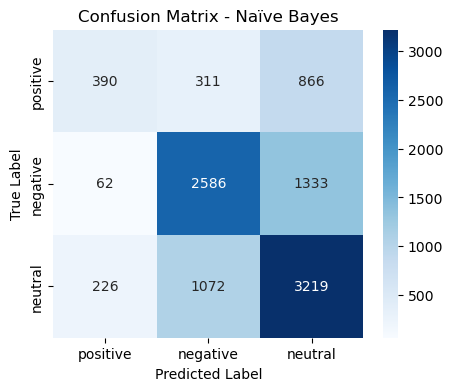

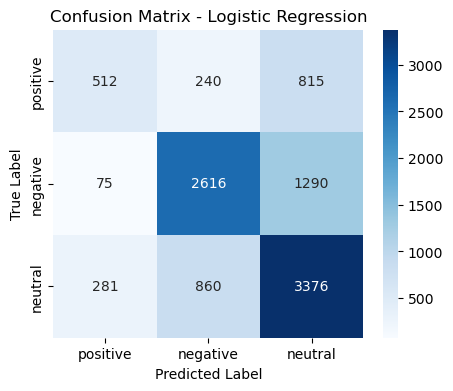

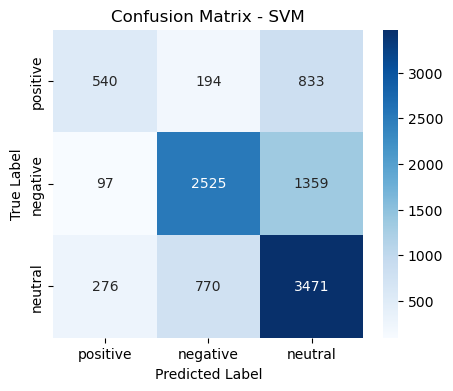

In [23]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(y_test, y_pred_nb, "Naïve Bayes")
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
